Load the raster

In [3]:
import os
data_folder = "Data"
cuprite_nevada_folder = "Cuprite Nevada"

filename = "ENMAP01-____L2A-DT0000025905_20230707T192008Z_001_V010303_20230922T131734Z-SPECTRAL_IMAGE.TIF"

raster_path = os.path.join(data_folder, cuprite_nevada_folder, filename)

In [4]:
from Raster import Raster

raster = Raster(path=raster_path)

Clip to ROI

In [5]:
import geopandas as gpd
from vector_utils import clip_raster
import utils

polygon_path = os.path.join(data_folder, cuprite_nevada_folder, "ROI.geojson")

polygon = gpd.read_file(polygon_path)
raster = clip_raster(raster, polygon)

Reprojecting GeoDataFrame from EPSG:4326 to EPSG:32611


Preprocess: handle missing bands, rescale by gain and offset, convert units to um, and concentrate by removing bands.

In [ ]:
raster = utils.preprocess(raster)

Get a target mineral reference spectrum

In [6]:
from Spectrum import Spectrum

ref_spectrum = Spectrum(mineral_name="kaolinite")
ref_spectrum.preprocess(desired_wavelengths=raster.wavelength)

Text(0, 0.5, 'Reflectance')

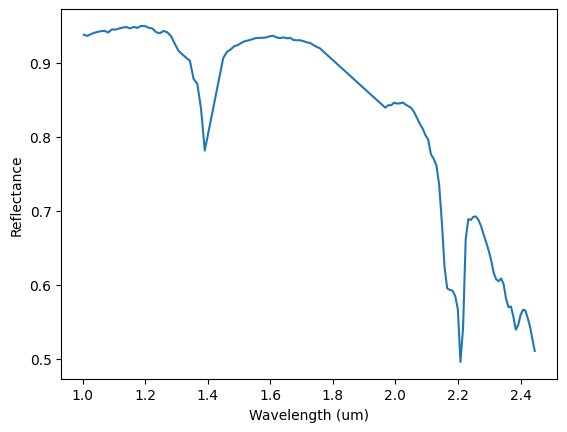

In [8]:
import matplotlib.pyplot as plt

plt.plot(ref_spectrum.wavelength, ref_spectrum.reflectance)
plt.xlabel("Wavelength (um)")
plt.ylabel("Reflectance")

Mineral mapping

In [9]:
import numpy as np

sam_score = utils.spectralMatch(raster, ref_spectrum, method="sam")  # TODO
threshold = 0.07
masked_sam_score = np.ma.masked_greater(sam_score, threshold)

c:\Users\NathanWeinstein\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Metric `SpectralAngleMapper` will save all targets and predictions in the buffer when using`reduction=None` or `reduction='none'. For large datasets, this may lead to a large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


Reprojecting GeoDataFrame from EPSG:4326 to EPSG:32611


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


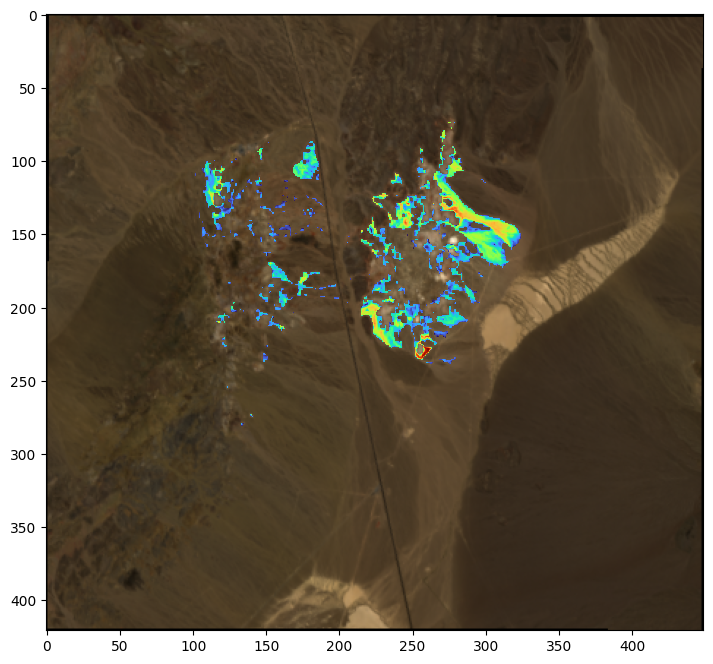

In [11]:
# Plot the results
# RGB from the hyperspectral image
raster_for_rgb = Raster(path=raster_path)
raster_for_rgb = clip_raster(raster_for_rgb, polygon)

rgb_indices = utils.get_rgb_indices(raster_for_rgb)

red = raster_for_rgb.datacube[rgb_indices[0], :, :]
green = raster_for_rgb.datacube[rgb_indices[1], :, :]
blue = raster_for_rgb.datacube[rgb_indices[2], :, :]

raster_for_rgb.datacube = np.stack([red, green, blue])

# Normalize the RGB datacube
raster_data = raster_for_rgb.datacube
raster_data = raster_data.astype(float)  # Convert to float for normalization
raster_data /= raster_data.max()  # Normalize to 0-1

# Rearrange the axes to (height, width, channels)
rgb_image = np.transpose(raster_data, (1, 2, 0))

plt.figure(figsize=(10, 8))
plt.imshow(rgb_image)
plt.imshow(masked_sam_score, cmap="turbo_r")

In [12]:
plt.savefig('map.svg', format='svg')

<Figure size 640x480 with 0 Axes>

Inspect a ROI: look at the highest mineral match (warmer color), at the southest detection (use row and columns).
There are good indicative absorbtions at 2.16 and 2.20 um, and two smaller absoprtions at 2.31 and 2.38 um of Kaolinite mineral!

Text(0, 0.5, 'Reflectance')

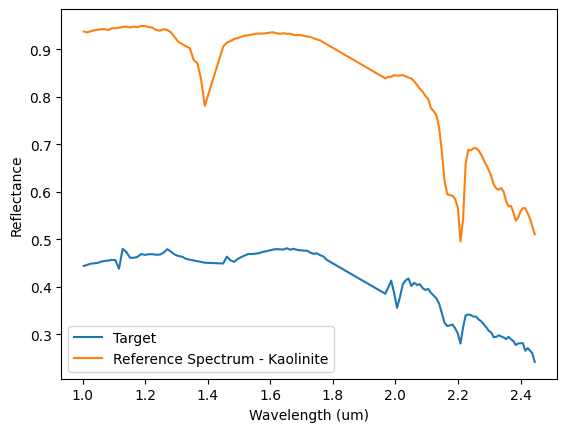

In [18]:
row, col = 230, 260

target_spec = raster.datacube[:, row, col]

plt.figure()
plt.plot(raster.wavelength, target_spec)
plt.plot(raster.wavelength, ref_spectrum.reflectance)
plt.legend(["Target", "Reference Spectrum - Kaolinite"])
plt.xlabel("Wavelength (um)")
plt.ylabel("Reflectance")

In [14]:
plt.savefig('spectrum.svg', format='svg')

<Figure size 640x480 with 0 Axes>